In [70]:
import pandas as pd

# Чтение CSV файлов
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Переименование колонки "Цена на арматуру" на "price"
train_df.rename(columns={'Цена на арматуру': 'price'}, inplace=True)
test_df.rename(columns={'Цена на арматуру': 'price'}, inplace=True)

# Преобразование колонки "Data" в формат datetime
train_df['dt'] = pd.to_datetime(train_df['dt'])
test_df['dt'] = pd.to_datetime(test_df['dt'])

# Объединение двух DataFrame
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Сохранение объединенного DataFrame в новый CSV файл
combined_df.to_csv('combined.csv', index=False)

print("Объединение завершено. Результат сохранен в 'combined.csv'.")

Объединение завершено. Результат сохранен в 'combined.csv'.


In [71]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# Step 1: Load and preprocess the data
def load_and_preprocess_data(file_path):
    # Load data
    data = pd.read_csv('combined.csv')

    # Convert date column to datetime
    data['dt'] = pd.to_datetime(data['dt'])

    # Create additional features
    data['week'] = data['dt'].dt.isocalendar().week
    data['year'] = data['dt'].dt.year
    data['month'] = data['dt'].dt.month

    # Assuming 'price' is the target variable and other columns are features
    X = data.drop(['price'], axis=1)
    y = data['price']

    return X, y

# Step 2: Train the CatBoost model
def train_model(X, y):
    model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=100)
    model.fit(X, y)
    return model

# Step 3: Make predictions
def make_predictions(model, X):
    return model.predict(X)

# Step 4: Recommend the number of weeks for procurement
def recommend_weeks(predicted_prices):
    recommendations = []
    for i in range(len(predicted_prices) - 1):
        current_price = predicted_prices[i]
        next_price = predicted_prices[i + 1]

        if next_price > current_price * 1.02:
            recommendations.append(6)  # Price is expected to rise significantly
        elif next_price > current_price:
            recommendations.append(4)  # Slight increase
        elif next_price < current_price * 0.98:
            recommendations.append(1)  # Price is expected to drop
        else:
            recommendations.append(3)  # Stable price

    # Fill the last recommendation with the last known value
    recommendations.append(recommendations[-1])
    return recommendations

# Step 5: Save predictions and recommendations to a CSV file
def save_predictions_to_csv(predicted_prices, recommendations, output_file):
    results = pd.DataFrame({
        'Predicted_Price': predicted_prices,
        'Recommended_Weeks': recommendations
    })
    results.to_csv(output_file, index=False)
    print(f"Predictions and recommendations saved to '{output_file}'.")

# Main function to run the script
def main():
    file_path = 'combined_data.csv'  # Path to the combined CSV file
    output_file = 'predictions_and_recommendations.csv'  # Output file for predictions

    X, y = load_and_preprocess_data(file_path)
    model = train_model(X, y)

    # Make predictions on the training data for recommendations
    predicted_prices = make_predictions(model, X)
    recommendations = recommend_weeks(predicted_prices)

    # Save predictions and recommendations to a CSV file
    save_predictions_to_csv(predicted_prices, recommendations, output_file)

if __name__ == "__main__":
    main()

0:	learn: 12596.2117734	total: 1.82ms	remaining: 1.82s
100:	learn: 2839.0654686	total: 226ms	remaining: 2.01s
200:	learn: 1736.6599992	total: 458ms	remaining: 1.82s
300:	learn: 1186.7120291	total: 705ms	remaining: 1.64s
400:	learn: 908.9498979	total: 942ms	remaining: 1.41s
500:	learn: 733.8621002	total: 1.17s	remaining: 1.17s
600:	learn: 622.8172556	total: 1.4s	remaining: 932ms
700:	learn: 546.9694337	total: 1.63s	remaining: 695ms
800:	learn: 489.8577582	total: 1.87s	remaining: 466ms
900:	learn: 447.5888474	total: 2.14s	remaining: 235ms
999:	learn: 410.6749376	total: 2.36s	remaining: 0us
Predictions and recommendations saved to 'predictions_and_recommendations.csv'.


Создаем и обучаем модельку 

Кросс-валидация (MSE): 12040092.80, RMSE: 3412.73
MSE на тестовой выборке: 12601470.22
MAE на тестовой выборке: 2435.22
R² на тестовой выборке: 0.92
RMSE на тестовой выборке: 3549.85


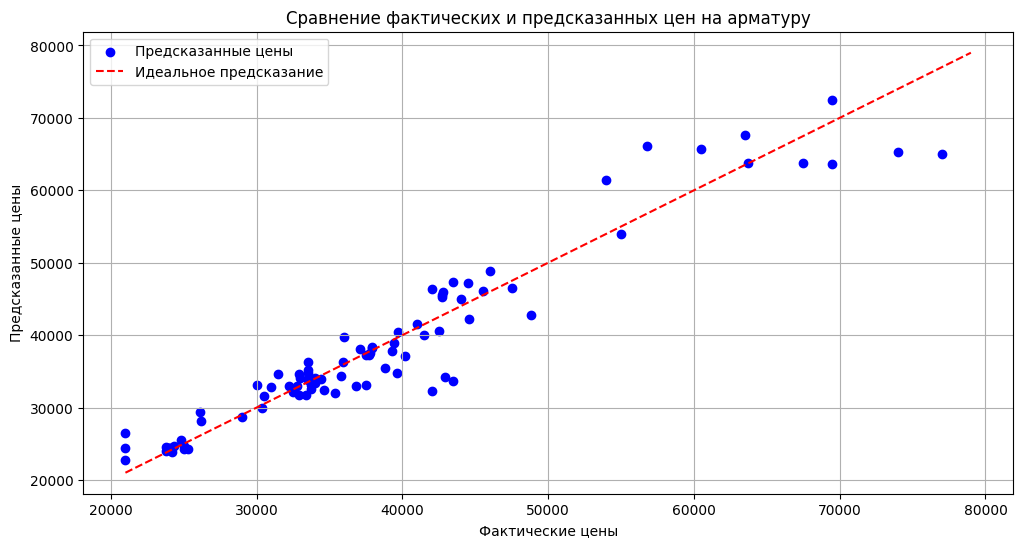

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib  # Импортируем библиотеку для сохранения модели
import matplotlib.pyplot as plt  # Импортируем библиотеку для визуализации

# Загрузка данных из CSV файла
data = pd.read_csv('combined.csv')

# Преобразование колонок с датами в формат datetime
if 'dt' in data.columns:  # Замените 'dt' на название вашей колонки с датами
    data['dt'] = pd.to_datetime(data['dt'])
    # Извлечение года, месяца и дня как отдельных признаков
    data['Year'] = data['dt'].dt.year
    data['Month'] = data['dt'].dt.month
    data['Day'] = data['dt'].dt.day
    data.drop(columns=['dt'], inplace=True)  # Удаляем оригинальную колонку с датами

# Предположим, что 'price' - это целевая переменная, а остальные - признаки
X = data.drop(columns=['price'])
y = data['price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Кросс-валидация
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores  # Преобразуем отрицательные значения MSE
rmse_scores = np.sqrt(mse_scores)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print(f"Кросс-валидация (MSE): {mse_scores.mean():.2f}, RMSE: {rmse_scores.mean():.2f}")
print(f"MSE на тестовой выборке: {mse:.2f}")
print(f"MAE на тестовой выборке: {mae:.2f}")
print(f"R² на тестовой выборке: {r2:.2f}")
print(f"RMSE на тестовой выборке: {rmse:.2f}")

# Визуализация фактических и предсказанных цен
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', label='Предсказанные цены')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Идеальное предсказание')
plt.xlabel('Фактические цены')
plt.ylabel('Предсказанные цены')
plt.title('Сравнение фактических и предсказанных цен на арматуру')
plt.legend()
plt.grid()
plt.show()

График фактических значений против предсказанных

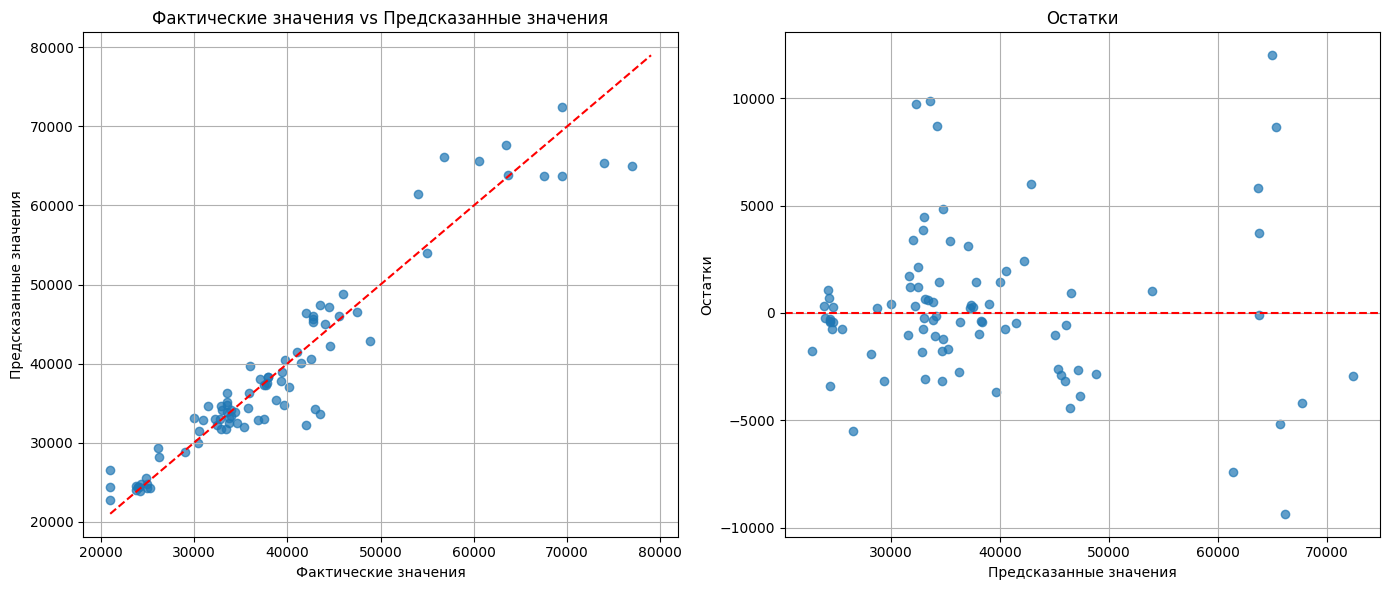

In [73]:

import matplotlib.pyplot as plt

# Визуализация
plt.figure(figsize=(14, 6))

# График фактических значений против предсказанных
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Линия y=x
plt.title('Фактические значения vs Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.grid()

# График остатков
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid()

plt.tight_layout()
plt.show()

Визуализация прогноза

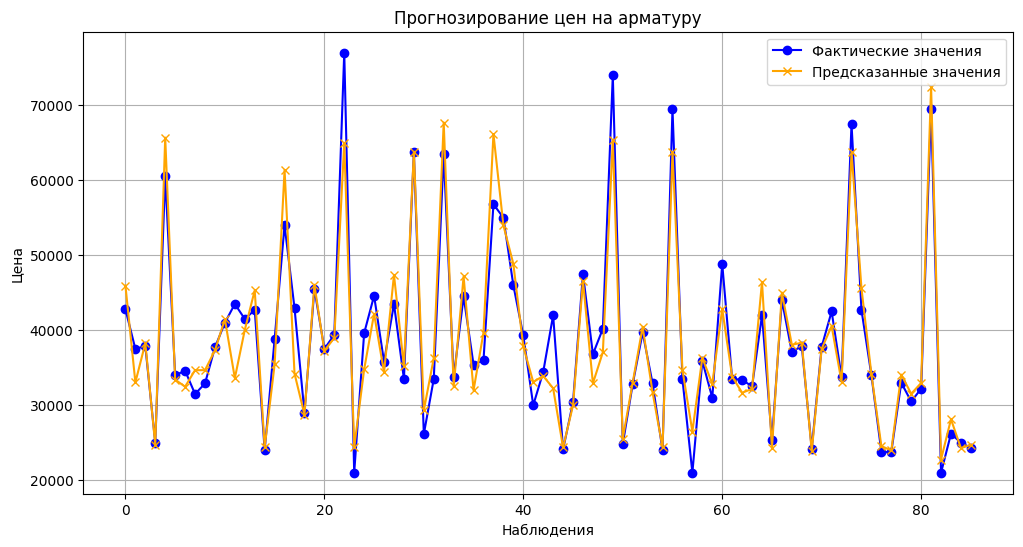

In [74]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Фактические значения', color='blue', marker='o')
plt.plot(y_pred, label='Предсказанные значения', color='orange', marker='x')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Наблюдения')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

Сохраняем модель

In [75]:
# Функция для сохранения модели
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Модель сохранена в {filename}")

# Сохранение модели
save_model(model, 'random_forest_model.joblib')

Модель сохранена в random_forest_model.joblib


Загружаем обученную модель

In [76]:
# Загрузка предобученной модели
model = joblib.load('random_forest_model.joblib')  # Укажите путь к вашей модели

Прогназируем объем тендера на арматуру

In [77]:
import pandas as pd
from datetime import timedelta
import joblib
import matplotlib.pyplot as plt

# Загрузка предобученной модели
model = joblib.load('random_forest_model.joblib')  # Укажите путь к вашей модели

# Функция для подготовки данных и прогнозирования
def recommend_tender_volume(data, model, N, last_date):
    recommendations = []
    dates = []  # Список для хранения дат предсказаний
    
    # Прогнозируем на N недель вперед
    for i in range(N):
        # Создаем новые признаки на основе last_date
        new_data = pd.DataFrame({
            'Year': [last_date.year],
            'Month': [last_date.month],
            'Day': [last_date.day],
            # Добавьте другие признаки, которые использовались при обучении модели
        })
        
        # Проверка на наличие необходимых признаков
        if not all(col in new_data.columns for col in model.feature_names_in_):
            raise ValueError("Отсутствуют необходимые признаки для предсказания.")
        
        # Прогнозируем объем тендера на следующую неделю
        predicted_volume = model.predict(new_data)
        recommendations.append(predicted_volume[0])  # Сохраняем предсказанное значение
        dates.append(last_date)  # Сохраняем дату предсказания
        
        # Обновление даты для следующей итерации
        last_date += timedelta(weeks=1)
        
    return recommendations, dates

# Пример использования
# Загрузка исторических данных
data = pd.read_csv('combined.csv')  # Укажите путь к вашему CSV файлу

# Укажите количество недель для прогноза
N = 4  # Например, прогноз на 4 недели

# Укажите последнюю дату в ваших данных
last_date = pd.to_datetime('2023-03-13')  # Замените на вашу последнюю дату

# Получение рекомендаций по объему тендера
tender_recommendations, prediction_dates = recommend_tender_volume(data, model, N, last_date)

# Вывод рекомендаций
for week, volume in enumerate(tender_recommendations, start=1):
    print(f"Рекомендация по объему тендера на неделю T+{week}: {volume:.2f}")

Рекомендация по объему тендера на неделю T+1: 53465.00
Рекомендация по объему тендера на неделю T+2: 53839.00
Рекомендация по объему тендера на неделю T+3: 53264.00
Рекомендация по объему тендера на неделю T+4: 52527.00


Визуализируем прогноз

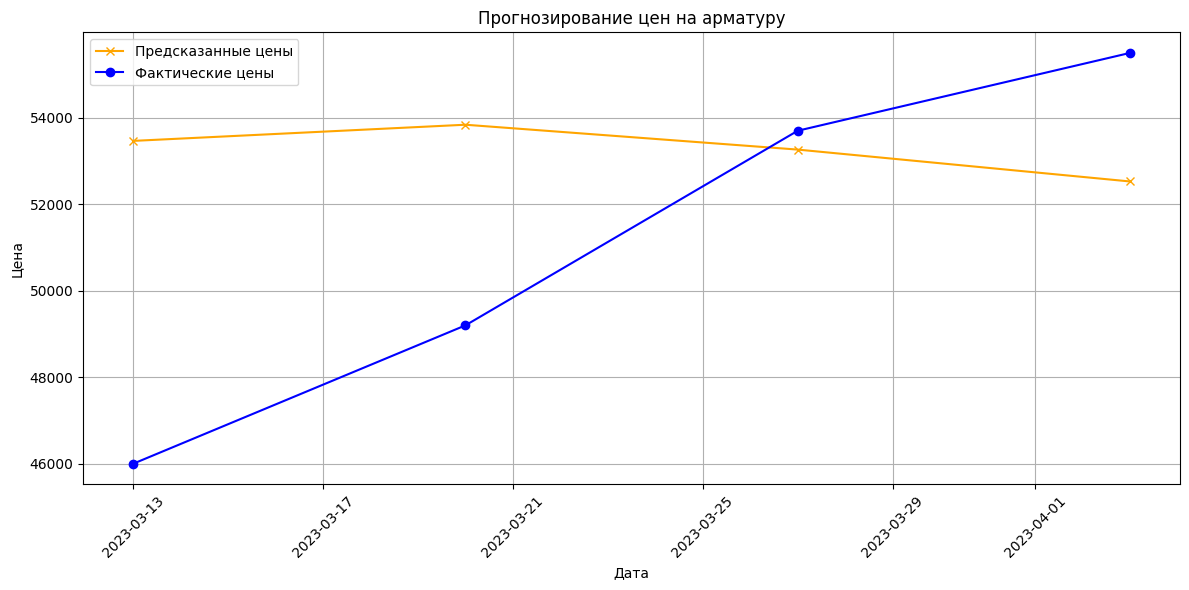

In [78]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))

# Предположим, что в data есть колонка 'price' с фактическими ценами
# Для графика используем последние фактические цены
actual_prices = data['price'].tail(N).reset_index(drop=True)

# Построение графика
plt.plot(prediction_dates, tender_recommendations, label='Предсказанные цены', color='orange', marker='x')
plt.plot(prediction_dates, actual_prices, label='Фактические цены', color='blue', marker='o')

plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Проверяем работу модели

Среднеквадратичная ошибка (MSE): 3815723.57
Коэффициент детерминации (R²): 0.98


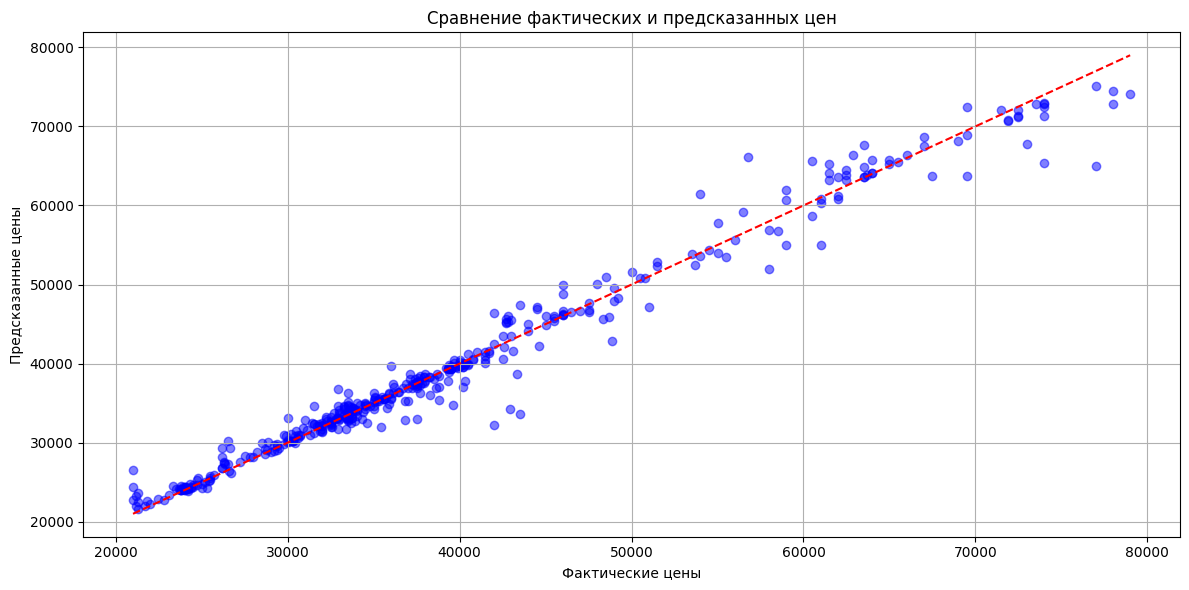

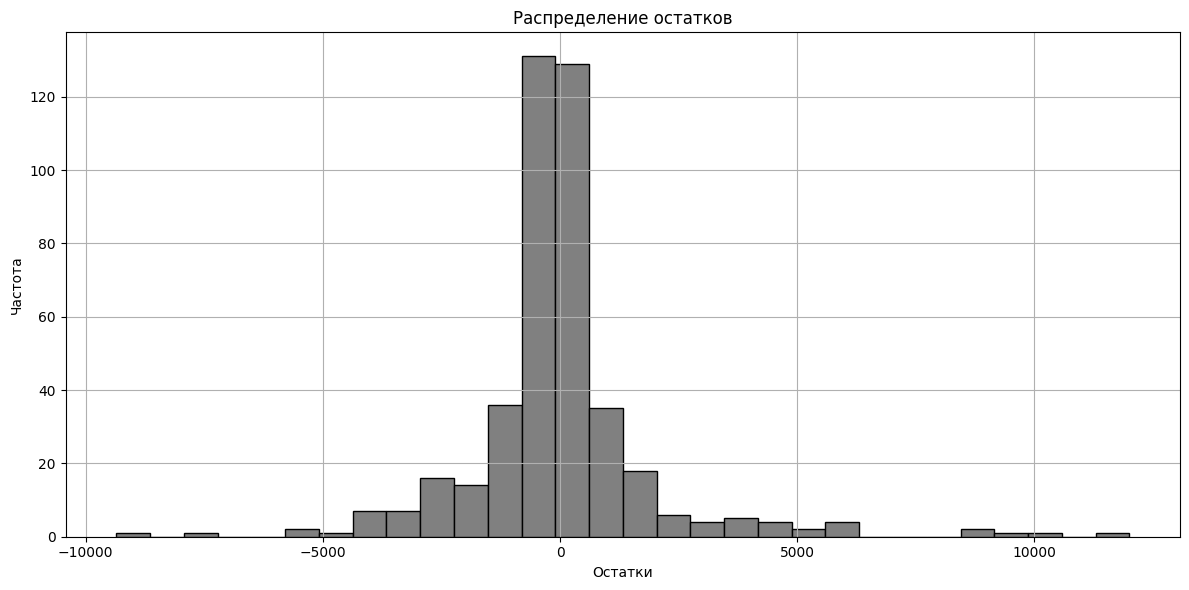

In [79]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Загрузка предобученной модели
model = joblib.load('random_forest_model.joblib')  # Укажите путь к вашей модели

# Загрузка тестового набора данных
test_data = pd.read_csv('combined.csv')  # Укажите путь к вашему тестовому CSV файлу

# Предполагаем, что в test_data есть колонка 'date' с датами
# Если у вас нет колонки 'date', убедитесь, что вы добавили ее
test_data['dt'] = pd.to_datetime(test_data['dt'])  # Преобразование в datetime, если это необходимо

# Извлечение признаков из даты
test_data['Year'] = test_data['dt'].dt.year
test_data['Month'] = test_data['dt'].dt.month
test_data['Day'] = test_data['dt'].dt.day

# Подготовка данных для предсказания
X_test = test_data[['Year', 'Month', 'Day']]  # Убедитесь, что вы используете все необходимые признаки
y_test = test_data['price']  # Предполагаем, что 'price' - это целевая переменная

# Прогнозирование на тестовом наборе данных
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Среднеквадратичная ошибка (MSE): {mse:.2f}')
print(f'Коэффициент детерминации (R²): {r2:.2f}')

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Линия идеального прогноза
plt.title('Сравнение фактических и предсказанных цен')
plt.xlabel('Фактические цены')
plt.ylabel('Предсказанные цены')
plt.grid()
plt.tight_layout()
plt.show()

# Проверка предположений модели (например, нормальность остатков)
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='gray', edgecolor='black')
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

Создаем и обучем еще одну модель

In [80]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка данных из combined.csv
data = pd.read_csv('combined.csv')

# Проверка наличия необходимых столбцов
if 'dt' not in data.columns:
    raise KeyError("Столбец 'dt' отсутствует в combined.csv.")
if 'price' not in data.columns:
    raise KeyError("Столбец 'price' отсутствует в combined.csv.")

# Преобразование даты в pandas datetime
data['dt'] = pd.to_datetime(data['dt'])

# Создание дополнительных признаков
data['day_of_week'] = data['dt'].dt.dayofweek
data['month'] = data['dt'].dt.month
data['year'] = data['dt'].dt.year
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Определение признаков и целевой переменной
X = data.drop(['price', 'dt'], axis=1)
y = data['price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение параметров модели
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'verbose': 100,
    'random_seed': 42
}

# Создание и обучение модели CatBoost
model = CatBoostRegressor(**params)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_val)

# Вычисление метрик
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}')
print(f'Корень из среднеквадратичной ошибки (RMSE): {rmse:.2f}')
print(f'Коэффициент детерминации (R²): {r2:.2f}')

# Оптимизация гиперпараметров с помощью Grid Search
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший RMSE: {(-grid_search.best_score_) ** 0.5:.2f}')

0:	learn: 12760.5984258	total: 1.53ms	remaining: 1.53s
100:	learn: 3334.0336279	total: 126ms	remaining: 1.12s
200:	learn: 2434.7336257	total: 284ms	remaining: 1.13s
300:	learn: 2085.4137089	total: 417ms	remaining: 968ms
400:	learn: 1918.4796853	total: 534ms	remaining: 798ms
500:	learn: 1843.7376423	total: 647ms	remaining: 644ms
600:	learn: 1811.1991176	total: 765ms	remaining: 508ms
700:	learn: 1794.6127897	total: 882ms	remaining: 376ms
800:	learn: 1786.2217995	total: 1.01s	remaining: 251ms
900:	learn: 1781.9258262	total: 1.13s	remaining: 124ms
999:	learn: 1779.4033178	total: 1.25s	remaining: 0us
Средняя абсолютная ошибка (MAE): 1291.26
Корень из среднеквадратичной ошибки (RMSE): 2278.68
Коэффициент детерминации (R²): 0.97
0:	learn: 13206.7013497	total: 786us	remaining: 393ms
100:	learn: 7657.0014774	total: 82.3ms	remaining: 325ms
200:	learn: 5685.5915769	total: 200ms	remaining: 297ms
300:	learn: 4946.0957756	total: 286ms	remaining: 189ms
400:	learn: 4468.2705576	total: 393ms	remaining:

KeyboardInterrupt: 

Проверка работы

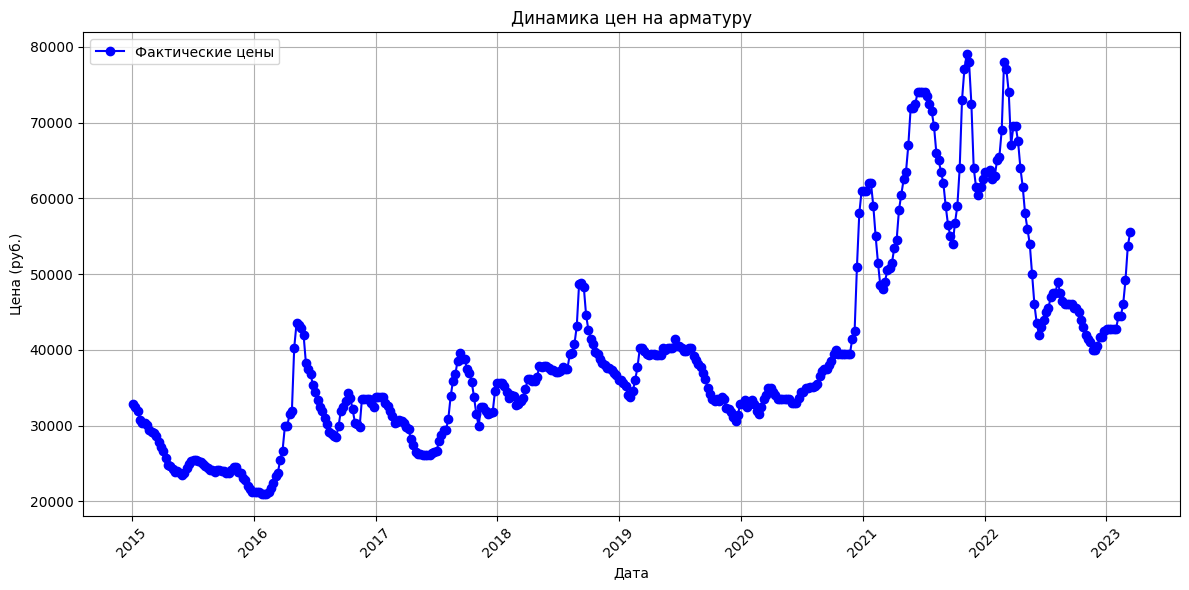

In [ ]:
import matplotlib.pyplot as plt

# Построение графика зависимости цен на арматуру
plt.figure(figsize=(12, 6))
plt.plot(data['dt'], data['price'], marker='o', linestyle='-', color='b', label='Фактические цены')
plt.title('Динамика цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена (руб.)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

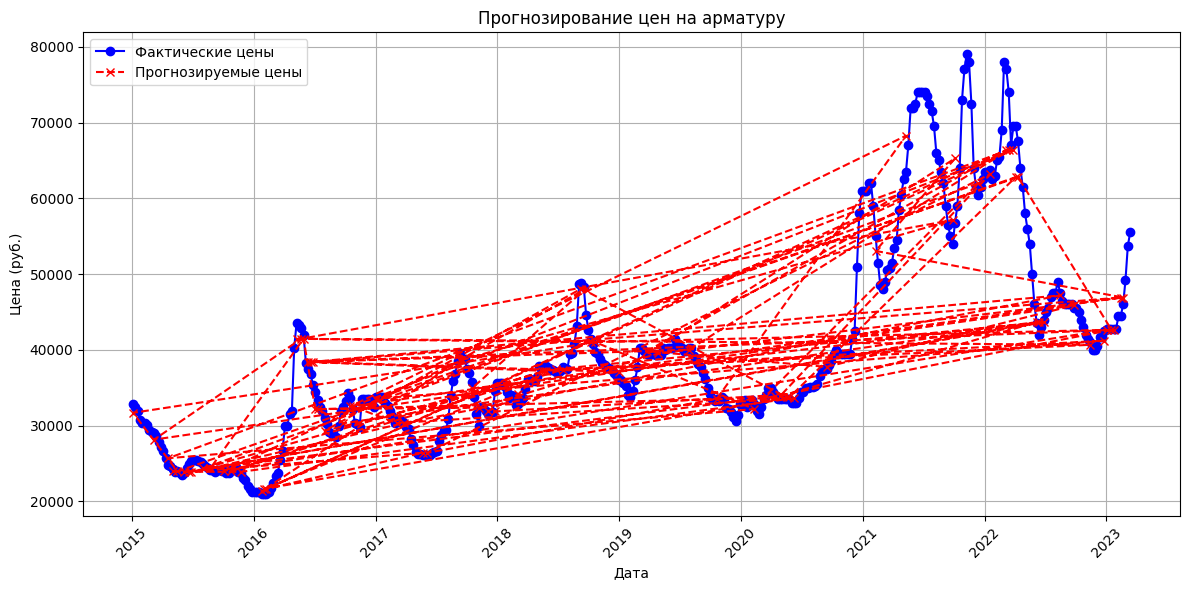

In [ ]:
# Построение графика фактических и прогнозируемых цен
plt.figure(figsize=(12, 6))

# График фактических цен
plt.plot(data['dt'], data['price'], marker='o', linestyle='-', color='b', label='Фактические цены')

# График прогнозируемых цен
# Объединяем даты валидационной выборки с прогнозами
val_dates = data['dt'].iloc[X_val.index]
plt.plot(val_dates, y_pred, marker='x', linestyle='--', color='r', label='Прогнозируемые цены')

plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена (руб.)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Метрики качества модели:
R2: 0.91
MSE: 12020590.00
MAE: 2626.87
MAPE: 4.64
SMAPE: 4.63


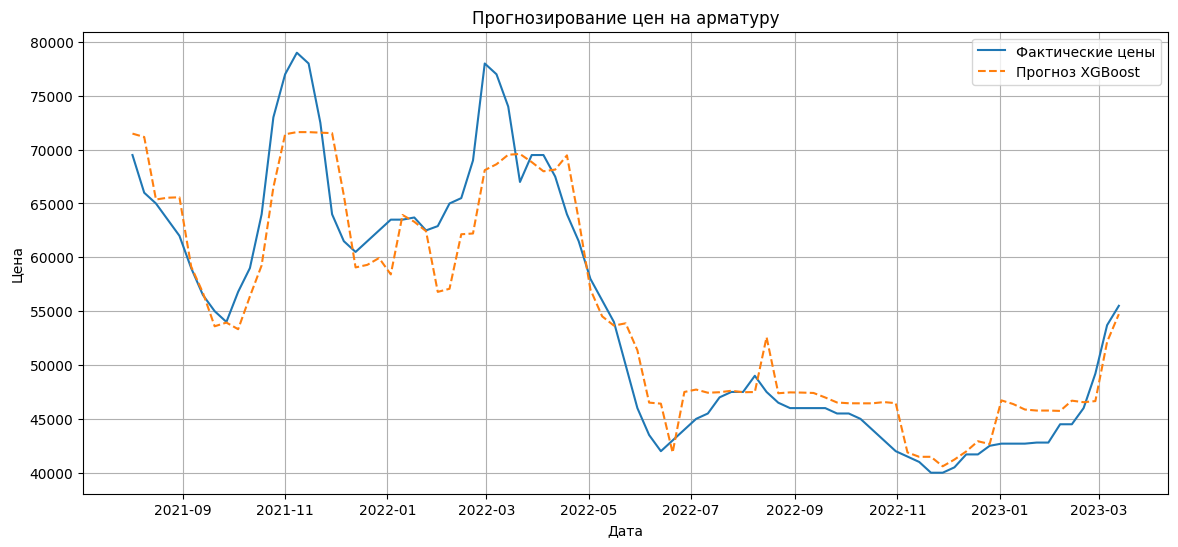

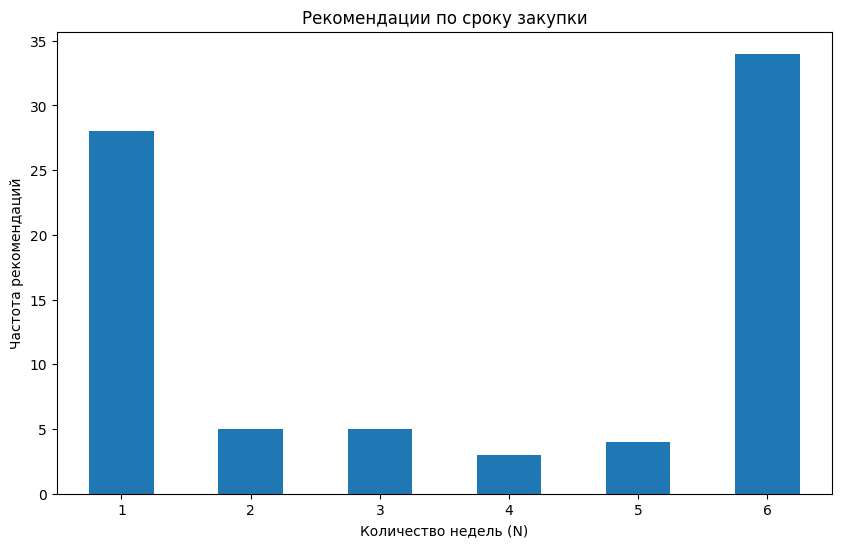

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Загрузка данных
df = pd.read_csv('combined.csv', parse_dates=['dt'])
df = df.rename(columns={'Цена на арматуру': 'price'})

# Проверка наличия необходимых колонок
assert 'price' in df.columns, "Колонка с ценой не найдена"
assert 'dt' in df.columns, "Колонка с датой не найдена"

# Создание временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week_of_year'] = df['dt'].dt.isocalendar().week
    
    for lag in range(1, 7):
        df[f'price_lag_{lag}'] = df['price'].shift(lag)
    
    df['rolling_mean_4'] = df['price'].rolling(4).mean().shift(1)
    df['rolling_std_4'] = df['price'].rolling(4).std().shift(1)
    return df

df = create_features(df).dropna()

# Разделение данных
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(['dt', 'price'], axis=1)
y_train = train['price']
X_test = test.drop(['dt', 'price'], axis=1)
y_test = test['price']

# Обучение модели
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Сохранение модели с метаданными
model_data = {
    'model': model,
    'features': X_train.columns.tolist(),
    'metrics': {
        'R2': r2_score(y_test, model.predict(X_test)),
        'MSE': mean_squared_error(y_test, model.predict(X_test)),
        'MAE': mean_absolute_error(y_test, model.predict(X_test))
    }
}

joblib.dump(model_data, "xgboost_model.pkl")

# Прогнозирование и оценка
y_pred = model.predict(X_test)

# Метрики качества
metrics = {
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': np.mean(np.abs((y_test - y_pred)/y_test)*100),
    'SMAPE': 100/len(y_test)*np.sum(2*np.abs(y_pred-y_test)/(np.abs(y_test)+np.abs(y_pred)))
}

print("Метрики качества модели:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

# Визуализация прогнозов
plt.figure(figsize=(14,6))
plt.plot(test['dt'], y_test, label='Фактические цены')
plt.plot(test['dt'], y_pred, label='Прогноз XGBoost', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

# Генерация рекомендаций
def calculate_optimal_N(current_price, predictions):
    savings = []
    for N in range(1,7):
        predicted_total = sum(predictions[:N])
        fixed_total = current_price * N
        savings.append(fixed_total - predicted_total)
    return np.argmax(savings) + 1

recommendations = []
for i in range(len(y_test)-6):
    window_pred = y_pred[i:i+6]
    current_price = y_test.iloc[i]
    recommendations.append(calculate_optimal_N(current_price, window_pred))

# Анализ рекомендаций
plt.figure(figsize=(10,6))
pd.Series(recommendations).value_counts().sort_index().plot(kind='bar')
plt.title('Рекомендации по сроку закупки')
plt.xlabel('Количество недель (N)')
plt.ylabel('Частота рекомендаций')
plt.xticks(rotation=0)
plt.show()